In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import magpylib as magpy
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from magpylib_material_response import meshing, demag
from nn_magnetics.utils import relative_amplitude_error, angle_error
from nn_magnetics.models.networks import AngleAmpCorrectionNetwork, QuaternionNet
from nn_magnetics.data import AnisotropicData
from nn_magnetics.utils.physics import demagnetizing_factor
from nn_magnetics.utils.plotting import plot_histograms, plot_heatmaps

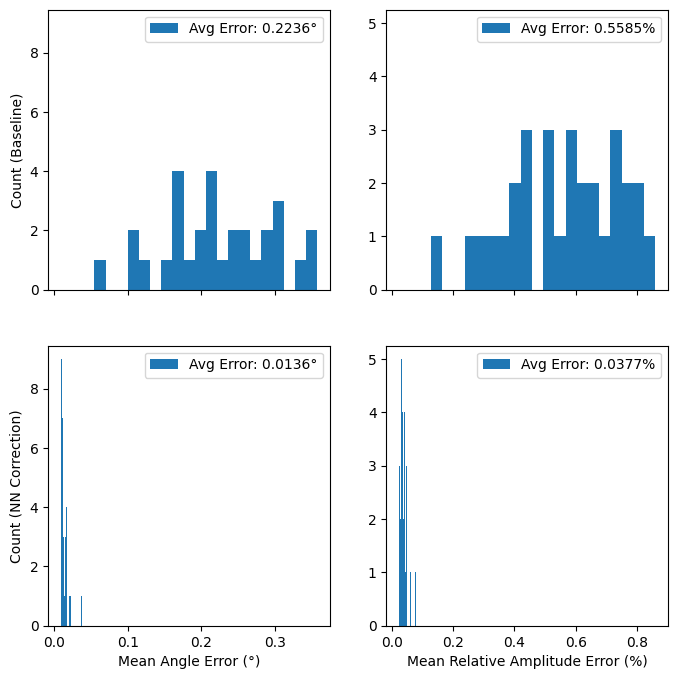

In [3]:
model = QuaternionNet.load_from_path(
    "/Users/jacksmith/Documents/PhD/nn-magnetics/results/3dof_chi_quaternion/2025-03-04 13:08:34.930357/best_weights.pt",
    24,
    activation=torch.nn.functional.silu,
    save_path=None,
    save_weights=False,
    do_output_activation=True,
).to(torch.float64)

data = AnisotropicData("../data/3dof_chi/test")

Xs, Bs = data.get_magnets()

plot_histograms(Xs, Bs, model, None)

In [24]:
height = np.unique(Xs[2,:,5:].T[1])[0]

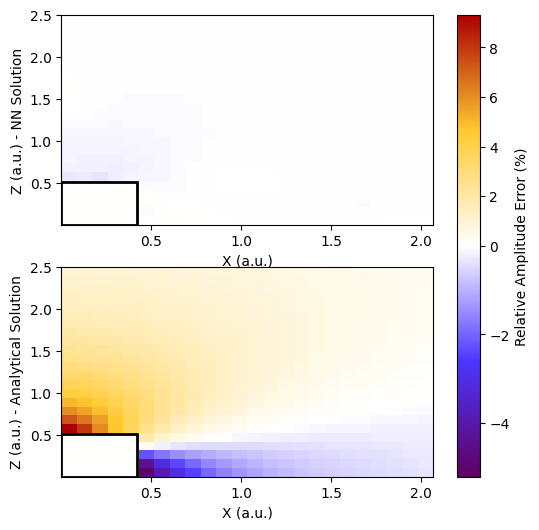

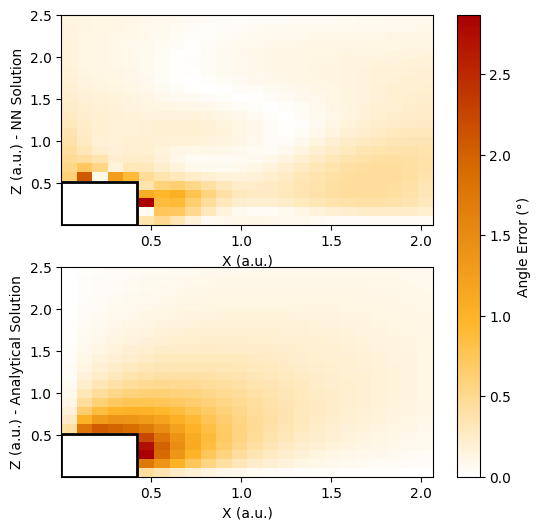

In [26]:
plot_heatmaps(model, Xs[2], Bs[2], None, height=None)